# Generalized Hodgkin-Huxley of an intrinsically bursting neuron

Here, the propagation of an "action potential", a spike of activity, along an axon (the part of a neuron along which the signal travels) is studied using the Hodgkin-Huxley model which has governing equation:

$$ C_{M} \frac{\partial V}{\partial t} = \frac{a}{2r_{L}}\frac{\partial^{2}V}{\partial x^{2}} + \sum_{j} \mathbf{I}_{j} $$

where $C_{M}$ is the membrane capacitance, $r_{L}$ is the resistivity inside the cell, and $I_{j}$ are ionic currents for each ion (e.g. Na, Ca, K, SI,). Here, 10 currents are considered, and the entire axon is considered spatially uniform, which means the equation describing the time-evolution of the membrane voltage due to external stimulation $I_{stim}$ is now:

$$ C_{M} \dot{V} = - \sum_{j} \mathbf{I}_{j} + I_{stim} $$

Here again, the data generating code written by Callaham is used. This matlab code numerically integrates the system of ODE's describe in in pages 2121-2123 of the Canavier, Clark and Byrne (1991) [paper](https://journals.physiology.org/doi/abs/10.1152/jn.1991.66.6.2107).

Generated by this code are the following variables:
- V, the membrane voltage (in mV)
- t (time), in ms
- The ionic currents: $I_{Ca}$ (ICa), $I_{CaP}$ (ICaP), $I_{SI}$ (IISI), $I_{K}$ (IK), $I_{L}$(IL), $I_{R}$ (IR), $I_{NS}$ (INS), $I_{Na}$ (INa), $I_{NaCa}$ (INaCa), $I_{NaK}$ (INaK), also in mV
- dV, which is calculated as the negative of the sum of the above currents, divided by Cm, or looking at the equation above is the $\dot{V}$ term.

In [196]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA
import sklearn as sk
import sys

sys.path.insert(0, "../Tools/")
import plot_funcs as pf

In [197]:
# Set the colormap
cm = sns.color_palette("tab10").as_hex()
cm.insert(0, "#ffffff")
cm = ListedColormap(cm)
cm.set_bad("darkgrey")

## 1. Load the data

In [198]:
# Load the data
data = sio.loadmat("../Data/burst_data.mat")

# Load the variables
V = data["V"]
t = data["time"]
I_Ca = data["ICa"]
I_CaP = data["ICaP"]
I_SI = data["IISI"]
I_K = data["IK"]
I_L = data["IL"]
I_R = data["IR"]
I_NS = data["INS"]
I_Na = data["INa"]
I_NaCa = data["INaCa"]
I_NaK = data["INaK"]
V_dot = data["dV"]
C_M = data["Cm"]

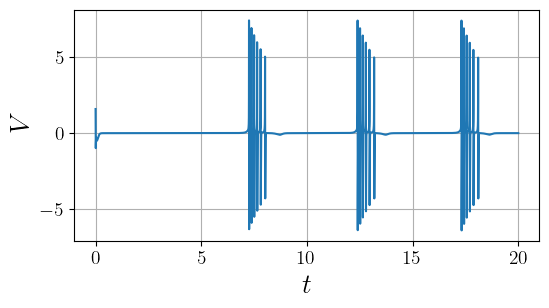

In [199]:
plt.figure(figsize=(6, 3))
plt.plot(t, V_dot)

plt.xlabel("$t$")
plt.ylabel(r"$V$")
plt.grid()

plt.gca().set_axisbelow(True)
plt.show()

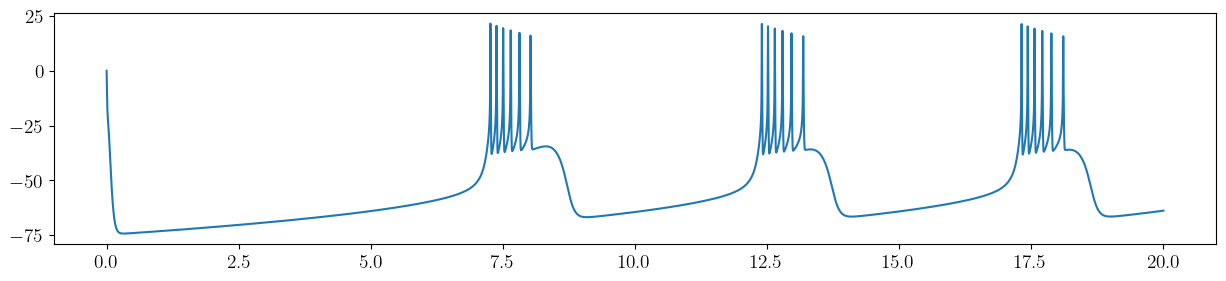

In [200]:
plt.plot(t, V)

## 2. Get the features

Again, the order of the features follows the terms laid out in the supplementary information. However, the first term is written as Right Hand Side as it is not clear whether the $C_M$ scaling should be ignored (i.e. not having the terms balance out as is required, see Supplementary Information section on Spurious Terms) even though the paper seems to have $\dot{V}$ as a term on its own.

In [201]:
features = pd.DataFrame(
    {
        "RHS": C_M.flatten() * V_dot.flatten(),
        "I_Ca": I_Ca.flatten(),
        "I_CaP": I_CaP.flatten(),
        "I_SI": I_SI.flatten(),
        "I_K": I_K.flatten(),
        "I_L": I_L.flatten(),
        "I_R": I_R.flatten(),
        "I_NS": I_NS.flatten(),
        "I_Na": I_Na.flatten(),
        "I_NaCa": I_NaCa.flatten(),
        "I_NaK": I_NaK.repeat(len(I_NaCa)),
    }
)
nfeatures = features.shape[1]

In [202]:
features

,RHS,I_Ca,I_CaP,I_SI,I_K,I_L,I_R,I_NS,I_Na,I_NaCa,I_NaK
0,27.870593,-1.960664e-02,0.000000,-47.681680,13.779674,0.000000,2.249473,0.000000e+00,-3.584531e-01,0.999998,3.16
1,-17.259890,-4.829083e-04,8.828236,-3.105511,7.964423,-1.390617,3.025482,1.241777e+00,-2.363151e+00,-0.100266,3.16
2,-17.246090,-4.814464e-04,8.828231,-3.105691,7.959704,-1.391603,3.026042,1.238592e+00,-2.368084e+00,-0.100621,3.16
3,-17.232295,-4.799896e-04,8.828227,-3.105871,7.954990,-1.392588,3.026603,1.235413e+00,-2.373022e+00,-0.100977,3.16
4,-17.218505,-4.785379e-04,8.828222,-3.106050,7.950279,-1.393573,3.027162,1.232240e+00,-2.377965e+00,-0.101332,3.16
...,...,...,...,...,...,...,...,...,...,...,...
1998997,0.057090,-1.650630e-14,2.921514,-1.520010,0.000004,-6.390367,2.902223,-3.818775e-07,-3.555016e-08,-1.130453,3.16
1998998,0.057090,-1.650658e-14,2.921510,-1.520017,0.000004,-6.390364,2.902227,-3.818808e-07,-3.555079e-08,-1.130450,3.16
1998999,0.057090,-1.650686e-14,2.921505,-1.520023,0.000004,-6.390360,2.902231,-3.818841e-07,-3.555142e-08,-1.130446,3.16
1999000,0.057090,-1.650714e-14,2.921500,-1.520029,0.000004,-6.390357,2.902235,-3.818875e-07,-3.555204e-08,-1.130443,3.16


In [203]:
features = features.to_numpy()

## 2. Gaussian Mixture Model

Again, the alternative sklearn train_test split is used for getting a subset of the data to train the model on. Here, only 10% is used due to the large quantity of data. 

In [204]:
# Set a random seed
seed = 75016
np.random.seed(seed)

# Fit the model on 50% of the data
frac = 0.1
features_train, _ = sk.model_selection.train_test_split(
    features, train_size=frac, random_state=seed
)

n_clusters = 9
model = GaussianMixture(n_components=n_clusters, random_state=seed)
model.fit(features_train)

/Users/thomasbreitburd/anaconda3/envs/Project_24/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


GaussianMixture(n_components=9, random_state=75016)

In [205]:
# Define the labels
labels = [
    r"$RHS$",
    r"$\mathbf{I}_{Ca}$",
    r"$\mathbf{I}_{CaP}$",
    r"$\mathbf{I}_{SI}$",
    r"$\mathbf{I}_{K}$",
    r"$\mathbf{I}_{L}$",
    r"$\mathbf{I}_{R}$",
    r"$\mathbf{I}_{NS}$",
    r"$\mathbf{I}_{Na}$",
    r"$\mathbf{I}_{NaCa}$",
    r"$\mathbf{I}_{NaK}$",
]

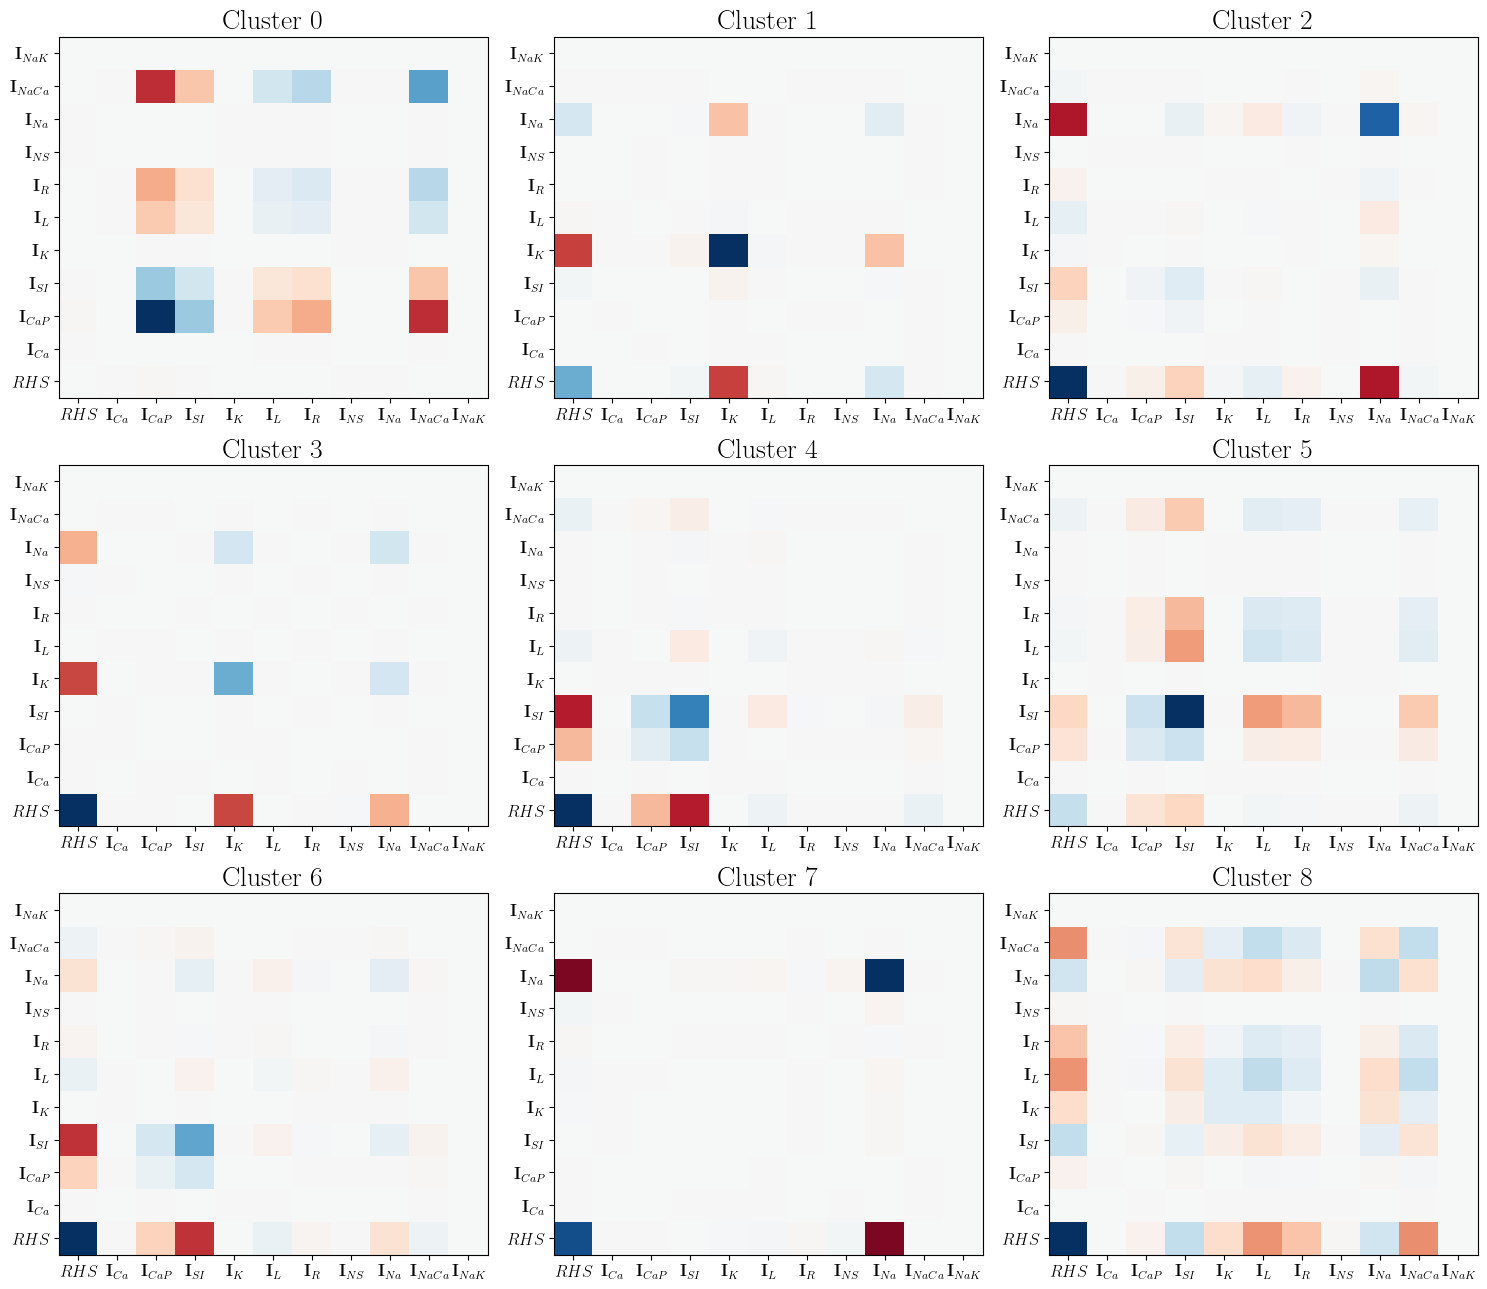

In [206]:
# Plot the covariance matrices of each cluster
pf.plot_cov_mat(model, nfeatures, n_clusters, labels, "GMM")

In [207]:
# Predict the clusters for the rest of the data
cluster_idx = model.predict(features)

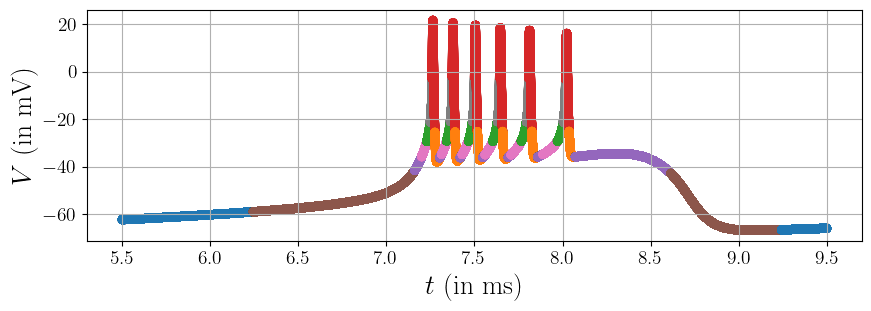

In [208]:
# Plot the clusters in the t - V plane
nt = len(t)

# Plot only a subset of the data to get only one of the bursts, as in the paper
idx = np.where((t > 5.5) & (t < 9.5))[0]
t_sub = t[idx]
V_sub = V[idx]
cluster_sub = cluster_idx[idx]


def plot_clusters_neuron(t, V, cluster):
    plt.figure(figsize=(10, 3))
    plt.scatter(t, V, c=cluster + 1, vmin=-0.5, vmax=cm.N - 0.5, cmap=cm, s=30)
    plt.xlabel("$t$ (in ms)")
    plt.ylabel("$V$ (in mV)")
    plt.grid()


# Plot the clusters
plot_clusters_neuron(t_sub, V_sub, cluster_sub)

## 3. Sparse PCA identification of active terms

The parallelising alternative code is used here, as usual. 

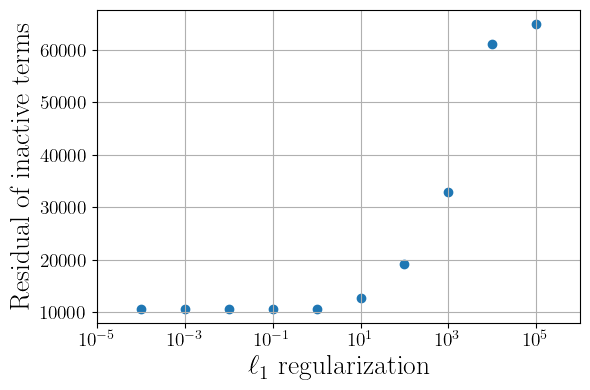

In [221]:
alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])


def spca_err(alpha, cluster_idx, features, nc):
    err_ = 0

    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.where(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        # Conduct Sparse PCA
        spca = SparsePCA(n_components=1, alpha=alpha)
        spca.fit(cluster_features)

        # Identify active and inactive terms
        active_terms = np.where(spca.components_[0] != 0)[0]
        inactive_terms = np.where(spca.components_[0] == 0)[0]

        err_ += np.sqrt(np.sum((cluster_features[:, inactive_terms].ravel()) ** 2))

    return err_


from joblib import Parallel, delayed

err = Parallel(n_jobs=4)(
    delayed(spca_err)(alpha, cluster_idx, features, n_clusters) for alpha in alphas
)

pf.plot_spca_residuals(alphas, err)

In [302]:
# Set the alpha regularization term to 40
alpha = 90
# Initialize the sparse PCA model
spca_model = np.zeros((n_clusters, nfeatures))

for i in range(n_clusters):
    feature_idx = np.where(cluster_idx == i)[0]
    cluster_features = features[feature_idx, :]

    spca = SparsePCA(n_components=1, alpha=alpha, random_state=seed)
    spca.fit(cluster_features)

    active_terms = np.where(spca.components_[0] != 0)[0]
    if len(active_terms) > 0:
        spca_model[i, active_terms] = 1  # Set the active terms to 1

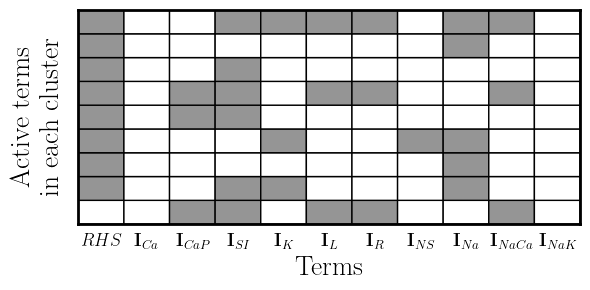

In [303]:
# Plot a grid with active terms in each cluster
gridmap = spca_model.copy()

plt.figure(figsize=(6, 3))

# Make a grid of the balance models
plt.pcolor(gridmap, edgecolors="k", linewidth=1, cmap="Greys", vmin=0, vmax=2)
plt.gca().set_xticks(np.arange(0.5, len(labels) + 0.5))
plt.gca().set_xticklabels(labels, fontsize=13)
plt.gca().set_yticklabels([])

for axis in ["top", "bottom", "left", "right"]:
    plt.gca().spines[axis].set_linewidth(2)

plt.gca().tick_params(axis="both", width=0)

plt.xlabel("Terms")
plt.ylabel("Active terms \n in each cluster")

plt.tight_layout()

plt.show()

When using an alpha value of 10, a too large amount of terms are considered active in each cluster. Thus the alpha value was increased until the number of active terms seemed to match the paper's results (values found 90-100). 

## 4. Get the unique balance models

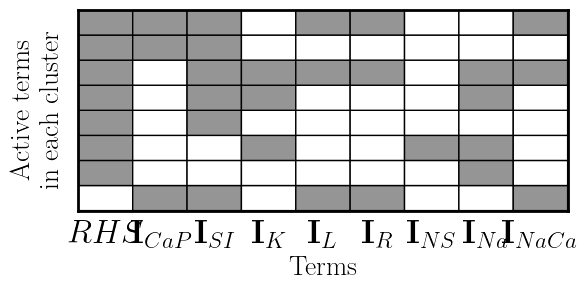

In [304]:
# Convert the spca_model array to a dataframe
spca_temp = pd.DataFrame(spca_model.copy())

# Group the balance models by the values of all columns
grouped_models = spca_temp.groupby(np.arange(nfeatures).tolist())
grouped_models = grouped_models.groups.items()

# Combine balance models that have identical active terms
# For each balance model, the spca models that have the same active terms
# are given the same index
balance_models = pd.DataFrame(np.zeros((len(grouped_models), nfeatures)))

model_idx = np.zeros(len(spca_model), dtype=int)
for i, model in enumerate(grouped_models):
    idx = model[1].to_list()
    model_idx[idx] = i
    balance_models.loc[i] = spca_temp.loc[idx[0]].to_numpy()

# Convert the balance models to a numpy array
balance_models = balance_models.drop_duplicates(keep="first")
balance_models = balance_models.to_numpy()
nmodels = balance_models.shape[0]

# Plot a grid of the active terms
pf.plot_active_terms(balance_models, labels)

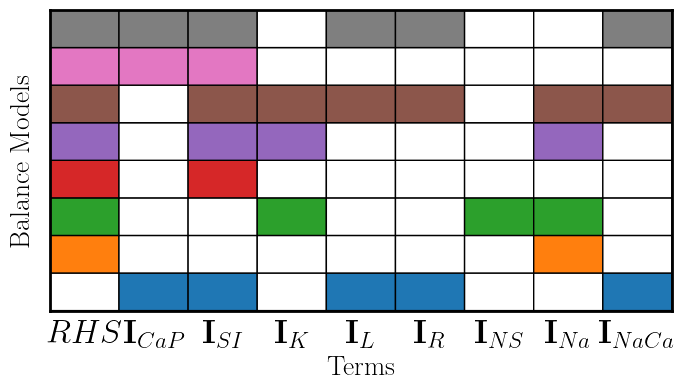

In [305]:
# Plot the balance models in a grid

# Create a grid with the balance models
balance_grid = balance_models.copy()
nmodels = balance_models.shape[0]
gridmask = np.where(balance_grid == 0)

# Assign a number to each balance model
cluster_number = np.arange(nmodels).reshape(nmodels, 1)
balance_grid = balance_grid * cluster_number + 1
balance_grid[gridmask] = 0

# Delete the terms that are inactive in all clusters
grid_mask = np.where(np.all(balance_grid == 0, axis=0))[0]
balance_grid = np.delete(balance_grid, grid_mask, axis=1)
grid_labels = np.delete(labels, grid_mask)


pf.plot_balance_models(balance_grid, grid_labels)

In [306]:
cluster_idx.shape

(1999002,)

In [307]:
# Assign new cluster indices
balance_idx = np.array([model_idx[i] for i in cluster_idx])
balance_idx.shape

(1999002,)

In [308]:
idx = np.where((t > 5.5) & (t < 9.5))[0]
cluster_sub = balance_idx[idx]

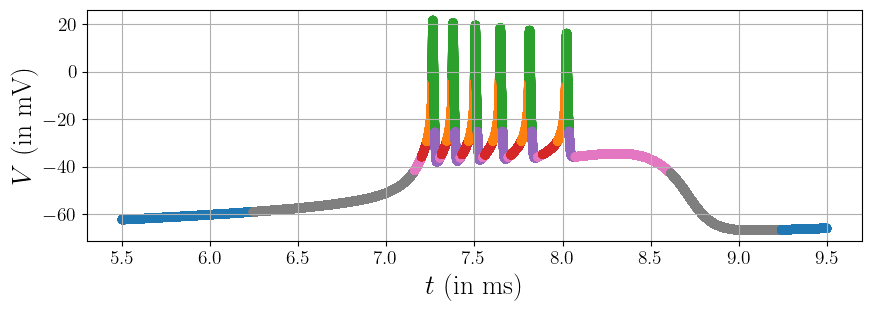

In [309]:
plot_clusters_neuron(t_sub, V_sub, cluster_sub)

In [320]:
def plot_clusters_neuron_terms(term_1, term_2, label_1, label_2, cluster):
    plt.figure(figsize=(5, 5))
    plt.scatter(term_1, term_2, c=cluster, vmin=-0.5, vmax=cm.N - 0.5, cmap=cm, s=3)
    plt.xlabel(r"{0}".format(label_1))
    plt.ylabel(r"{0}".format(label_2))
    plt.grid()

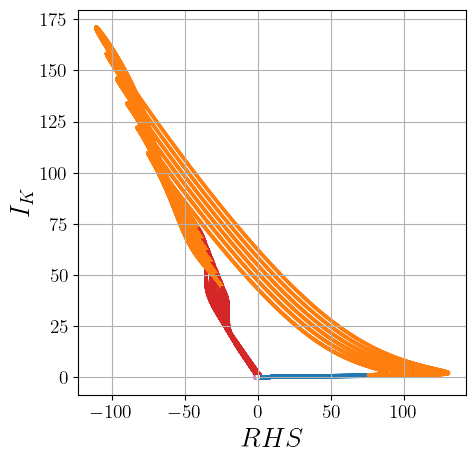

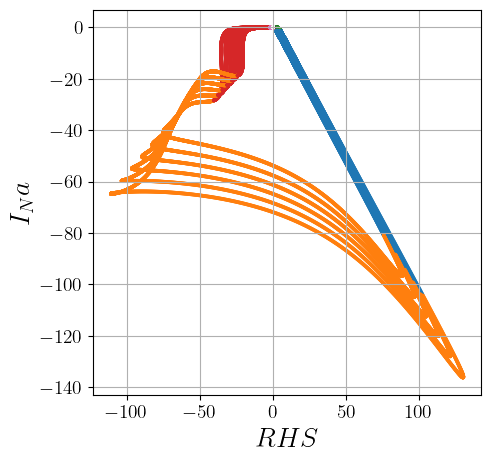

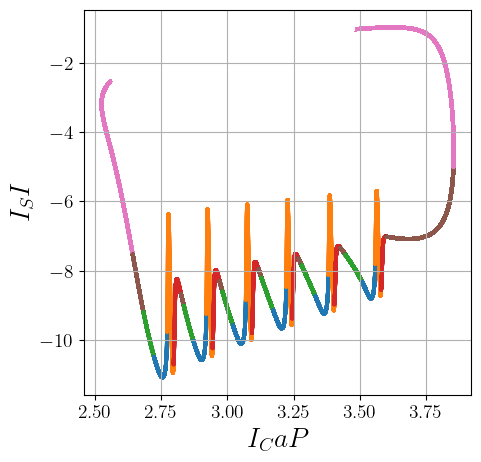

In [321]:
# Plot the clusters for 3 projections, as in the paper.
I_K_sub = I_K[idx]
RHS_sub = C_M[0] * V_dot[idx]
plot_clusters_neuron_terms(RHS_sub, I_K_sub, "$RHS$", "$I_K$", cluster_sub)

I_Na_sub = I_Na[idx]
plot_clusters_neuron_terms(RHS_sub, I_Na_sub, "$RHS$", "$I_Na$", cluster_sub)

ISI_sub = I_SI[idx]
I_CaP_sub = I_CaP[idx]
plot_clusters_neuron_terms(I_CaP_sub, ISI_sub, "$I_CaP$", "$I_SI$", cluster_sub)